# Can't figure out how to import Tslearn



In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns
import statistics
#import sklearn
import tslearn
import math 
import os
import scipy.stats as stats
import glob
import warnings

from statistics import mode

from scipy import signal
from scipy.signal import find_peaks, peak_prominences

from numpy.lib.stride_tricks import sliding_window_view

from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from tslearn.utils import to_time_series_dataset

# Import, Reorder & Label CSVs

In [13]:
path = '/Users/juliapersche/Desktop/darpa_datascience folder/A_DeviceMotion_data/User_1'
csv_files = glob.glob(os.path.join(path, "*.csv"))
print(csv_files)

['/Users/juliapersche/Desktop/darpa_datascience folder/A_DeviceMotion_data/User_1/jog_16_sub_1.csv', '/Users/juliapersche/Desktop/darpa_datascience folder/A_DeviceMotion_data/User_1/ups_12_sub_1.csv', '/Users/juliapersche/Desktop/darpa_datascience folder/A_DeviceMotion_data/User_1/jog_9_sub_1.csv', '/Users/juliapersche/Desktop/darpa_datascience folder/A_DeviceMotion_data/User_1/wlk_8_sub_1.csv', '/Users/juliapersche/Desktop/darpa_datascience folder/A_DeviceMotion_data/User_1/dws_11_sub_1.csv', '/Users/juliapersche/Desktop/darpa_datascience folder/A_DeviceMotion_data/User_1/dws_1_sub_1.csv', '/Users/juliapersche/Desktop/darpa_datascience folder/A_DeviceMotion_data/User_1/wlk_15_sub_1.csv', '/Users/juliapersche/Desktop/darpa_datascience folder/A_DeviceMotion_data/User_1/ups_4_sub_1.csv', '/Users/juliapersche/Desktop/darpa_datascience folder/A_DeviceMotion_data/User_1/dws_2_sub_1.csv', '/Users/juliapersche/Desktop/darpa_datascience folder/A_DeviceMotion_data/User_1/std_14_sub_1.csv', '/Us

In [14]:
indices = [0,2,4,5,8,3,6,10,9,11,1,7,12,13,14]
data = [csv_files[i] for i in indices]
print(data)

['/Users/juliapersche/Desktop/darpa_datascience folder/A_DeviceMotion_data/User_1/jog_16_sub_1.csv', '/Users/juliapersche/Desktop/darpa_datascience folder/A_DeviceMotion_data/User_1/jog_9_sub_1.csv', '/Users/juliapersche/Desktop/darpa_datascience folder/A_DeviceMotion_data/User_1/dws_11_sub_1.csv', '/Users/juliapersche/Desktop/darpa_datascience folder/A_DeviceMotion_data/User_1/dws_1_sub_1.csv', '/Users/juliapersche/Desktop/darpa_datascience folder/A_DeviceMotion_data/User_1/dws_2_sub_1.csv', '/Users/juliapersche/Desktop/darpa_datascience folder/A_DeviceMotion_data/User_1/wlk_8_sub_1.csv', '/Users/juliapersche/Desktop/darpa_datascience folder/A_DeviceMotion_data/User_1/wlk_15_sub_1.csv', '/Users/juliapersche/Desktop/darpa_datascience folder/A_DeviceMotion_data/User_1/wlk_7_sub_1.csv', '/Users/juliapersche/Desktop/darpa_datascience folder/A_DeviceMotion_data/User_1/std_14_sub_1.csv', '/Users/juliapersche/Desktop/darpa_datascience folder/A_DeviceMotion_data/User_1/std_6_sub_1.csv', '/Use

In [15]:
list_of_dfs = []
activities = ['jog', 'jog','dws','dws','dws', 'wlk','wlk', 'wlk','std','std','ups','ups','ups','sit','sit']
trials = [16,9,11,1,2,8,15,7,14,6,12,4,3,5,13]

counter = 0
for f in data:
       # read the csv file
        k = pd.read_csv(f).rename(columns={'Unnamed: 0': 'time'})
        #Label
        k['activity'] = counter
        k['trial'] = trials[counter]
        list_of_dfs.append(k)
        counter += 1
        

df = pd.concat(list_of_dfs).set_index('time')
df = df.drop(['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x', 'gravity.y', 'gravity.z'], axis=1)
df = df.rename(columns={'rotationRate.x': 'gyro_x', 'rotationRate.y': 'gyro_y', 'rotationRate.z': 'gyro_z'})

# Compute Accel Energy & Resample Data

In [16]:
df['x_norm'] = (df['userAcceleration.x'] - df['userAcceleration.x'].mean()) / (df['userAcceleration.x'].max() - df['userAcceleration.x'].min())
df['y_norm'] = (df['userAcceleration.y'] - df['userAcceleration.y'].mean()) / (df['userAcceleration.y'].max() - df['userAcceleration.y'].min())
df['z_norm'] = (df['userAcceleration.z'] - df['userAcceleration.z'].mean()) / (df['userAcceleration.z'].max() - df['userAcceleration.z'].min())

df['energy'] = (abs(df['x_norm']**2 + df['y_norm']**2 + df['z_norm']**2))**.5

df.head()

,gyro_x,gyro_y,gyro_z,userAcceleration.x,userAcceleration.y,userAcceleration.z,activity,trial,x_norm,y_norm,z_norm,energy
time,,,,,,,,,,,,
0,-0.255821,0.499133,-0.725292,0.778940,0.051810,-1.657163,0,16,0.097953,-0.001493,-0.202830,0.225249
1,-1.015571,-1.724624,-1.266134,0.613780,-0.112152,-0.879374,0,16,0.076751,-0.024399,-0.105607,0.132811
2,0.784464,-0.237245,-0.759811,0.413660,-0.630365,-0.428647,0,16,0.051060,-0.096795,-0.049267,0.120015
3,2.235062,-0.180857,-0.135523,0.372556,-0.915796,-0.859046,0,16,0.045783,-0.136671,-0.103066,0.177194
4,0.528382,-1.351467,0.512080,0.139503,-1.002214,-0.005295,0,16,0.015864,-0.148744,0.003652,0.149632


In [17]:
#resampling (from 50 to 20 Hz) --> unsure why resampled from 50 to 20 Hz
df['time'] = np.arange(0, len(df)*20, 20)
df['time'] = pd.to_timedelta(df['time'], unit='ms')
df = df.set_index('time')
df_resample = df.resample('50ms').mean()
df['time'] = df_resample.set_index
df

,gyro_x,gyro_y,gyro_z,userAcceleration.x,userAcceleration.y,userAcceleration.z,activity,trial,x_norm,y_norm,z_norm,energy,time
time,,,,,,,,,,,,,
0 days 00:00:00,-0.255821,0.499133,-0.725292,0.778940,0.051810,-1.657163,0,16,0.097953,-0.001493,-0.202830,0.225249,<bound method DataFrame.set_index of ...
0 days 00:00:00.020000,-1.015571,-1.724624,-1.266134,0.613780,-0.112152,-0.879374,0,16,0.076751,-0.024399,-0.105607,0.132811,<bound method DataFrame.set_index of ...
0 days 00:00:00.040000,0.784464,-0.237245,-0.759811,0.413660,-0.630365,-0.428647,0,16,0.051060,-0.096795,-0.049267,0.120015,<bound method DataFrame.set_index of ...
0 days 00:00:00.060000,2.235062,-0.180857,-0.135523,0.372556,-0.915796,-0.859046,0,16,0.045783,-0.136671,-0.103066,0.177194,<bound method DataFrame.set_index of ...
0 days 00:00:00.080000,0.528382,-1.351467,0.512080,0.139503,-1.002214,-0.005295,0,16,0.015864,-0.148744,0.003652,0.149632,<bound method DataFrame.set_index of ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:20:46.140000,-0.008201,-0.002056,-0.032352,0.000004,0.007707,-0.003506,14,13,-0.002044,-0.007654,0.003876,0.008820,<bound method DataFrame.set_index of ...
0 days 00:20:46.160000,-0.013541,-0.009469,-0.038790,-0.002688,0.006063,0.003011,14,13,-0.002390,-0.007884,0.004690,0.009480,<bound method DataFrame.set_index of ...
0 days 00:20:46.180000,-0.002946,-0.016997,-0.030162,0.001548,0.019090,-0.007339,14,13,-0.001846,-0.006064,0.003396,0.007191,<bound method DataFrame.set_index of ...


# Visualize Energy of Different Activities

Text(0, 0.5, 'walking \n energy')

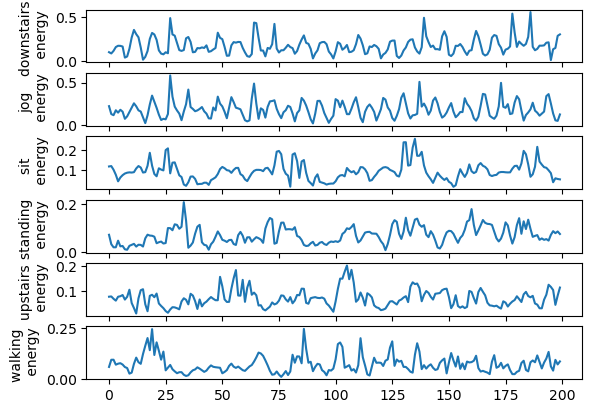

In [18]:
fig,ax = plt.subplots(figsize=(24,6))
fig, axs = plt.subplots(6, 1, sharex ='col')
x = np.arange(0,200,1)

axs[0].plot(x, df.loc[df['activity'] == 1]['energy'][0:200])
axs[0].set_ylabel('downstairs \n energy')
axs[1].plot(x, df.loc[df['activity'] == 0]['energy'][0:200])
axs[1].set_ylabel('jog \n energy')
axs[2].plot(x, df.loc[df['activity'] == 5]['energy'][0:200])
axs[2].set_ylabel('sit \n energy')
axs[3].plot(x, df.loc[df['activity'] == 3]['energy'][0:200])
axs[3].set_ylabel('standing \n energy')
axs[4].plot(x, df.loc[df['activity'] == 4]['energy'][0:200])
axs[4].set_ylabel('upstairs \n energy')
axs[5].plot(x, df.loc[df['activity'] == 2]['energy'][0:200])
axs[5].set_ylabel('walking \n energy')

In [19]:
#Splitting energy computed for each trial into 10 second windos with 5 second overlap
energy_windows = sliding_window_view(stats.zscore((df['energy']).to_numpy()), 200)[::150, :]

#Splitting up corresponding labels
activity_windows = sliding_window_view((df['activity']), 200)[::150, :]

energy_windows.shape
print(energy_windows)

[[ 2.27331057  1.0316734   0.85979543 ...  0.0488462  -0.03558578
   0.97301109]
 [ 2.07085231  2.75818303  1.42238174 ...  3.00204858  1.40877463
   0.44922452]
 [ 1.31547968  2.41307419  3.88564281 ...  6.77561681  2.52041236
   1.54169413]
 ...
 [-0.62325054 -0.62965387 -0.62634971 ... -0.61808483 -0.61798831
  -0.62539277]
 [-0.64136359 -0.62370875 -0.6140566  ... -0.62622272 -0.6608349
  -0.66789268]
 [-0.56742651 -0.56692067 -0.56272833 ... -0.65907003 -0.6168253
  -0.60879608]]


# Create Dictionary with keys for each activity and corresponding windows 
### This dictionary will serve as 'ground truth' when determining the accuracy of the kmeans clustering assignment for each unlabeled energy window.

In [20]:
activity_labels = [statistics.mode(x) for x in activity_windows]
activity_splits = {}
for i, act in enumerate(activity_labels):
    activity = activities[act]
    if activity_splits.get(activity) == None:
        activity_splits[activity] = []
    activity_splits[activity].append(i)

print(activity_splits)

#Printing number of activities in each key 
for key, value in activity_splits.items():
    #print value
    print(key, len([item for item in value if item]))

{'jog': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42], 'dws': [43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76], 'wlk': [77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150], 'std': [151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214,

### Remap assigned labels to actual activity labels 

In [21]:
#jog 0 --> 1 
#dws 1 --> 0 
#wlk 2 --> 2
#std 3 --> 5
#ups 4 --> 0 
#sit 5 --> 5 

for key, value in activity_splits.items():
    if key == 'jog':
          jog_label = np.full(len([item for item in value if item])+1, 1, dtype=int)
    if key == 'dws':
           dws_label = np.full(len([item for item in value if item]), 0, dtype=int)
    if key == 'wlk':
         wlk_label = np.full(len([item for item in value if item]), 2, dtype=int)
    if key == 'std':
         std_label = np.full(len([item for item in value if item]), 5, dtype=int)
    if key == 'ups':
         ups_label = np.full(len([item for item in value if item]), 0, dtype=int)
    if key == 'sit':
         sit_label = np.full(len([item for item in value if item]), 5, dtype=int)
    
labels = np.concatenate((jog_label,dws_label,wlk_label,std_label,ups_label,sit_label))
labels.shape
print(len(labels))

print(np.sum(labels==0))
print(labels)

415
76
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5]


# Createte Kmeans model with unlabeled Energy Windows
### Since we are working with Time Series Data, we expect to see a shift in the windows vs the cluster center segments.  To account for this, use Dynamic Time Warping

In [22]:
#Energy
k = 6
E = energy_windows
km_e = TimeSeriesKMeans(n_clusters=k, metric="softdtw", max_iter=50,
                         max_iter_barycenter=5,
                         random_state=0).fit(E)
#print(km_e.cluster_centers_)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Feed energy windows into kmeans model.  

In [23]:
predict = km_e.predict(E)
print(predict)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 415 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 3 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 5 0 0 0 0 0 0 2 2 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 5 0 2 0 0 0 2 2 2 2 0 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4]


In [24]:
#see which are correct
scores = (labels == predict)
#combining labeled and predicted cluster scores
actual_predicted = np.hstack([labels[:, np.newaxis], predict[:, np.newaxis],scores[:, np.newaxis]])
# #print(actual_predicted[0][2])

### Compute overall model accuracy

In [25]:
#actual_predicted_ts[i][2]
model_accuracy = (sum(scores)/len(scores)) *100
print(model_accuracy)

21.686746987951807


### Group model prediction for each cluster per activity

In [26]:
activities_list = ['jog', 'dws', 'wlk','std','ups','sit']

print("AX cluster scores")
for act in activities_list:
    print(act)
    predictE = km_e.predict(E[activity_splits[act]])
    print(predictE)
    print('-----') 

AX cluster scores
jog


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 43 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 3 0]
-----
dws


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 34 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


[0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
-----
wlk


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 74 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
-----
std


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 85 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 5]
-----
ups


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 42 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


[0 0 0 0 0 0 2 2 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 0 2 0 0 0 2 2 2 2
 0 2 2 2 2]
-----
sit


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 137 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
-----


In [27]:
for act in activities_list:
     predictE = km_e.predict(E[activity_splits[act]])
     if act == 'jog':
          jog_predict = np.array(predictE)
     if act == 'dws':
         dws_predict = np.array(predictE)
     if act == 'wlk':
         wlk_predict = np.array(predictE)
     if act == 'std':
         std_predict = np.array(predictE)
     if act == 'ups':
        ups_predict = np.array(predictE)
     if act == 'sit':
        sit_predict = np.array(predictE)
        
print(len(jog_predict))     
print(len(jog_label))  

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 43 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 34 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 74 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 85 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
/opt/homebrew/Ca

43
43


# Visualize Prediction Accuracy

In [28]:
window = np.arange(0,415,1)
activityline_dict = {0:'jog begin', 1:'dws begin', 2: 'walk begin', 3:'std begin', 4: 'ups begin', 5: 'sit begin'}
activity_colorlabel_dict = {0:'orange', 1:'b', 2: 'k', 3:'c', 4: 'y', 5: 'm'}
activitylabel_dict = {0:'dws', 1:'jog', 2: 'wlk ', 3:'N/A', 4: 'walk ', 5: 'std / sit '}


activitystart_dict = {0:0, 1: 43, 2: 77, 3:151, 4: 236, 5: 278}
k = 6

scores_list = scores.tolist()
scores_list_len = len(scores_list)
score_colors = []

for j in range(scores_list_len):
    if scores[j] == 0:
      score_colors+= ["red"]
    if scores[j] == 1:
         score_colors+= ["green"]

score_colors = np.asarray(score_colors)
score_colors_dict = dict(zip(window, score_colors))

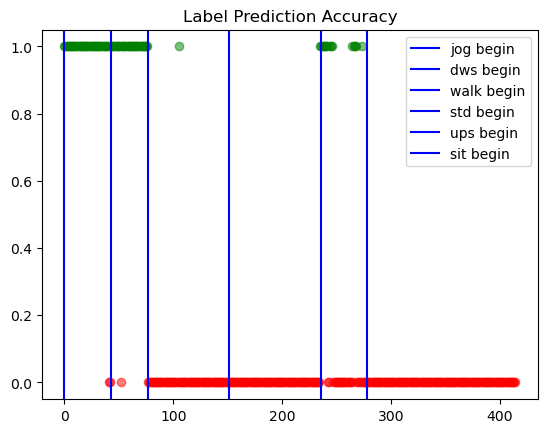

In [29]:
fig,ax = plt.subplots(figsize=(24,6))

for i in range(k):
   plt.axvline(x = activitystart_dict[i], color = 'b', label = activityline_dict[i])

for j in range(scores_list_len):
   plt.scatter(window[j],scores[j],color = score_colors_dict[j],alpha = .5)

plt.rcParams["figure.figsize"] = [30,6]
plt.legend()
plt.title('Label Prediction Accuracy')
plt.show()

# Visualize actual vs predicted activity for each windo

In [30]:
predictedlabels_colors = []
actuallabels_colors = []
for j in range(scores_list_len):
    if labels[j] == 0:
      actuallabels_colors+= ['orange']
    if labels[j] == 1:
        actuallabels_colors+= ['b']
    if labels[j] == 2:
        actuallabels_colors+= ['k']
    if labels[j] == 3:
         actuallabels_colors+= ['c']
    if labels[j] == 4:
         actuallabels_colors+= ['y']
    if labels[j] == 5:
         actuallabels_colors+= ['m']

    for r in range(scores_list_len):
        if predict[r] == 0:
            predictedlabels_colors += ['orange']
        if predict[r] == 1:
            predictedlabels_colors += ['b']
        if predict[r] == 2:
            predictedlabels_colors += ['k']
        if predict[r] == 3:
            predictedlabels_colors += ['c']
        if predict[r] == 4:
            predictedlabels_colors += ['y']
        if predict[r] == 5:
            predictedlabels_colors += ['m']


actuallabels_colors = np.asarray(actuallabels_colors)
actuallabels_colors_dict = dict(zip(window, actuallabels_colors))

predictedlabels_colors = np.asarray( predictedlabels_colors)
predictedlabels_colors_dict = dict(zip(window,  predictedlabels_colors))
print(predictedlabels_colors_dict)

{0: 'b', 1: 'b', 2: 'b', 3: 'b', 4: 'b', 5: 'b', 6: 'b', 7: 'b', 8: 'b', 9: 'b', 10: 'b', 11: 'b', 12: 'b', 13: 'b', 14: 'b', 15: 'b', 16: 'b', 17: 'b', 18: 'b', 19: 'b', 20: 'b', 21: 'b', 22: 'b', 23: 'b', 24: 'b', 25: 'b', 26: 'b', 27: 'b', 28: 'b', 29: 'b', 30: 'b', 31: 'b', 32: 'b', 33: 'b', 34: 'b', 35: 'b', 36: 'b', 37: 'b', 38: 'b', 39: 'b', 40: 'b', 41: 'c', 42: 'orange', 43: 'orange', 44: 'orange', 45: 'orange', 46: 'orange', 47: 'orange', 48: 'orange', 49: 'orange', 50: 'orange', 51: 'orange', 52: 'k', 53: 'orange', 54: 'orange', 55: 'orange', 56: 'orange', 57: 'orange', 58: 'orange', 59: 'orange', 60: 'orange', 61: 'orange', 62: 'orange', 63: 'orange', 64: 'orange', 65: 'orange', 66: 'orange', 67: 'orange', 68: 'orange', 69: 'orange', 70: 'orange', 71: 'orange', 72: 'orange', 73: 'orange', 74: 'orange', 75: 'orange', 76: 'orange', 77: 'c', 78: 'c', 79: 'c', 80: 'c', 81: 'c', 82: 'c', 83: 'c', 84: 'c', 85: 'c', 86: 'c', 87: 'c', 88: 'c', 89: 'c', 90: 'c', 91: 'c', 92: 'c', 93

Text(0.5, 0, 'Window')

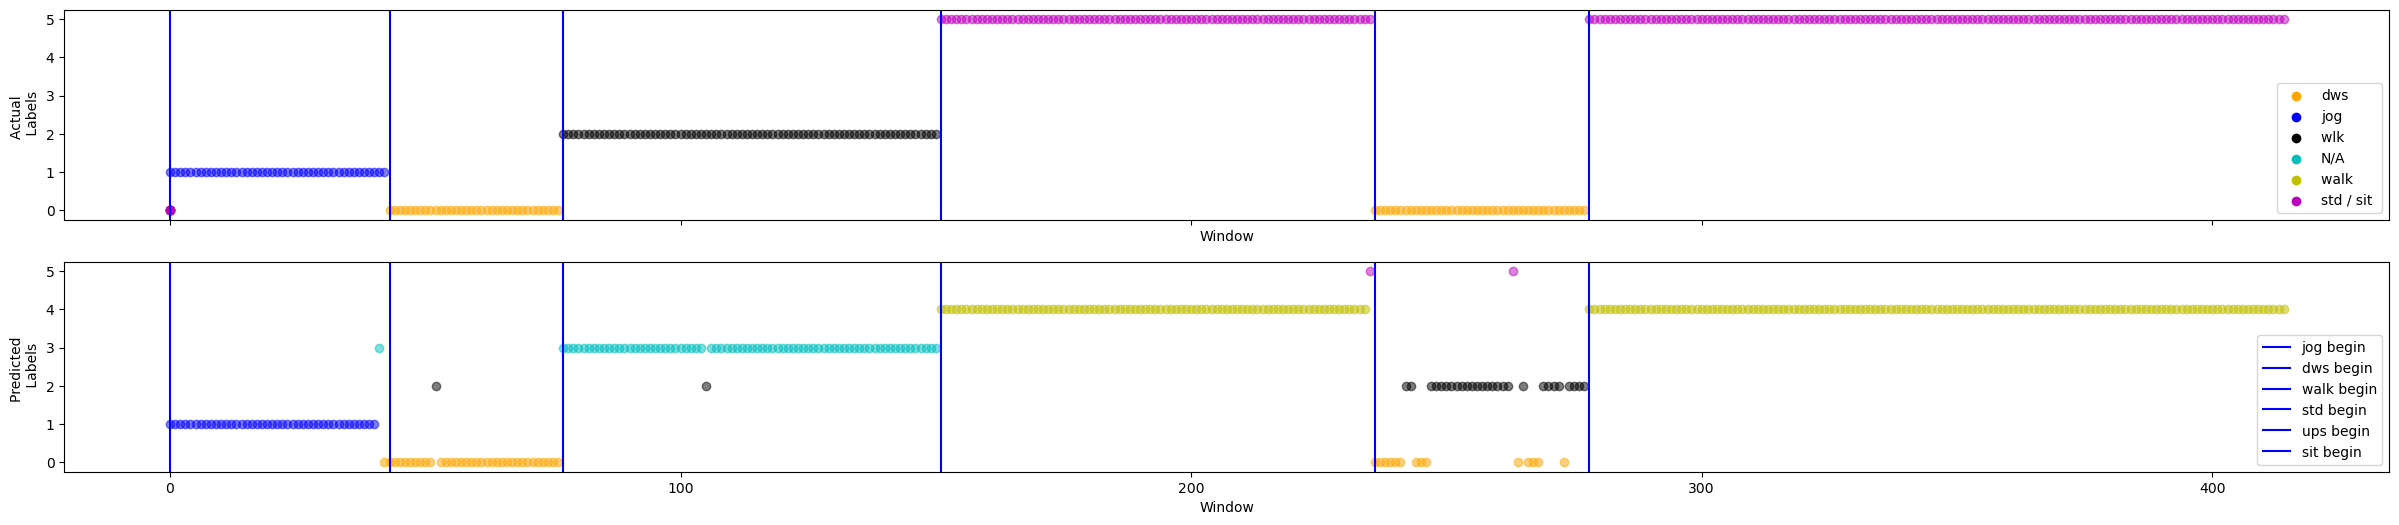

In [31]:
fig,ax = plt.subplots(figsize=(24,6))
fig, axs = plt.subplots(2, 1, sharex ='col')

for i in range(k):
   axs[0].axvline(x = activitystart_dict[i], color = 'b')
   axs[0].scatter(x = 0,y=0, color = activity_colorlabel_dict[i], label = activitylabel_dict[i])
   axs[0].legend()

for j in range(scores_list_len):
    axs[0].scatter(window[j],labels[j],color = actuallabels_colors_dict[j],alpha = .5)

axs[0].set_ylabel('Actual \n Labels')
axs[0].set_xlabel('Window')


for i in range(k):
   axs[1].axvline(x = activitystart_dict[i], color = 'b', label = activityline_dict[i])
   axs[1].legend()

for j in range(scores_list_len):
    axs[1].scatter(window[j],predict[j],color = predictedlabels_colors_dict[j],alpha = .5)
axs[1].set_ylabel('Predicted \n Labels')
axs[1].set_xlabel('Window')

# Compute accuracy per activity & visualize in a confusion matrix

In [32]:
print('jog predict mode:', stats.mode(jog_predict), (stats.mode(jog_predict)[1][0]/len(jog_predict)*100))
print('dws predict mode:', stats.mode(dws_predict), (stats.mode(dws_predict)[1][0]/len(dws_predict))*100)
print('wlk predict mode:', stats.mode(wlk_predict), (stats.mode(wlk_predict)[1][0]/len(wlk_predict))*100)
print('std predict mode:', stats.mode(std_predict), (stats.mode(std_predict)[1][0]/len(std_predict))*100)
print('ups predict mode:', stats.mode(ups_predict), (stats.mode(ups_predict)[1][0]/len(ups_predict))*100)
print('sit predict mode:', stats.mode(sit_predict), (stats.mode(sit_predict)[1][0]/len(sit_predict))*100)

jog predict mode: ModeResult(mode=array([1]), count=array([41])) 95.34883720930233
dws predict mode: ModeResult(mode=array([0]), count=array([33])) 97.05882352941177
wlk predict mode: ModeResult(mode=array([3]), count=array([73])) 98.64864864864865
std predict mode: ModeResult(mode=array([4]), count=array([84])) 98.82352941176471
ups predict mode: ModeResult(mode=array([2]), count=array([27])) 64.28571428571429
sit predict mode: ModeResult(mode=array([4]), count=array([137])) 100.0


/var/folders/xv/_kt5cgd12jl2mt2z16gq8ryw0000gn/T/ipykernel_1845/2355887933.py:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print('jog predict mode:', stats.mode(jog_predict), (stats.mode(jog_predict)[1][0]/len(jog_predict)*100))
/var/folders/xv/_kt5cgd12jl2mt2z16gq8ryw0000gn/T/ipykernel_1845/2355887933.py:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the 